# Log-a-like outperforms NJ, BioNJ & Weighbor

For short sequences, this has to be demonstrated carefully, since the maximum likelihood tree and the generating tree do not necessarily have the same unrooted tree topology (due to sampling error).  We show that, with logalike, for short sequences:

1. the generating tree is recovered more often;
2. the likelihood of the found tree topology matches or exceeds that of the generating tree topology more often (the likelihood of the topology is the maximum of the likelihood over all choices of edge lengths).

For longer sequences, distance estimation becomes very accurate and then (of course) Weighbor and friends are just as able to recover the generating tree (=ML tree) every time.

In [26]:
pickle_fn = 'sequence-length-experiment-article.pickle'

In [27]:
from joblib import Parallel, delayed, parallel_backend
from analysis import load_experiments, tabulate_results, extract_constants, \
mean_normalised_rf_to_optimum, topological_accuracy_report, likelihood_report
import matplotlib.pyplot as plt
from experiment import Experiment
import pickle

In [28]:
tree_samples = 8
sequence_samples = 12
sequence_lengths = [100, 150, 200, 250, 300, 400, 500, 750]

with parallel_backend('loky', n_jobs=96):
    experiments = Parallel(max_nbytes=None)(
            delayed(Experiment)(
                tree_seed=tree_seed,
                num_leaves=30,
                min_length=0.05,
                max_length=0.2,
                sequence_length=sequence_length,
                sequence_seed=sequence_seed,
                dimension=30,
                rho=0.5,
                logalike_hyperparams=dict(lr=0.1, max_step_size=0.05, stopping_distance=5e-5, max_rounds=100000),
                haggl_hyperparams=dict(),
                mds_hyperparams=dict(),
            )
        for tree_seed in range(tree_samples)
        for sequence_seed in range(sequence_samples)
        for sequence_length in sequence_lengths
    )
    
    experiments = Parallel(max_nbytes=None)(
            delayed(Experiment.evaluate_method)(experiment, experiment.logalike)
            for experiment in experiments)
        
    experiments = Parallel(max_nbytes=None)(
            delayed(Experiment.evaluate_method)(experiment, experiment.weighbor)
            for experiment in experiments)
    
    experiments = Parallel(max_nbytes=None)(
            delayed(Experiment.evaluate_method)(experiment, experiment.bionj)
            for experiment in experiments)
    
    experiments = Parallel(max_nbytes=None)(
            delayed(Experiment.evaluate_method)(experiment, experiment.nj)
            for experiment in experiments)

with open(pickle_fn, 'wb') as f:
    pickle.dump(experiments, f)

In [29]:
with open(pickle_fn, 'rb') as f:
    experiments = pickle.load(f)

In [30]:
gbcol = 'sequence_length'

experiments = load_experiments(pickle_fn)
df = tabulate_results(experiments)
extract_constants(df)

num_leaves         30
min_length       0.05
max_length        0.2
dimension          30
rho               0.5
weighbor_meta    None
bionj_meta       None
nj_meta          None
Name: 0, dtype: object

In [31]:
figsize = (4.3, 4.3)

# w.r.t. the likelihood of the trees inferred

... i.e. how often does the inferred tree have a likelihood at least as high as that of the generating tree?

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


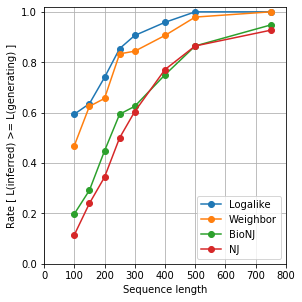

In [32]:
ll_aggs = likelihood_report(df, gbcol, tolerance=0)
ll_aggs.plot(marker='o', figsize=figsize)
plt.ylim(0, 1.02)
plt.xlim(0, 800)
plt.ylabel('Rate [ L(inferred) >= L(generating) ]')
plt.xlabel('Sequence length')
plt.grid()
plt.tight_layout()
plt.savefig('article/sequence-length-experiment-ll-article.eps')
plt.show()

# Mean RF distance to optimum

Lower values are better.

In [33]:
mnrf = mean_normalised_rf_to_optimum(df, gbcol)
mnrf

,Logalike,Weighbor,BioNJ,NJ
sequence_length,,,,
100,0.045139,0.057099,0.099537,0.134259
150,0.032022,0.034336,0.067515,0.078318
200,0.014275,0.020448,0.033179,0.050540
250,0.008102,0.009259,0.023920,0.031636
300,0.003472,0.006559,0.020062,0.023534
400,0.001543,0.003858,0.012346,0.013117
500,0.000386,0.000772,0.005787,0.006173
750,0.000000,0.000000,0.002315,0.003086


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


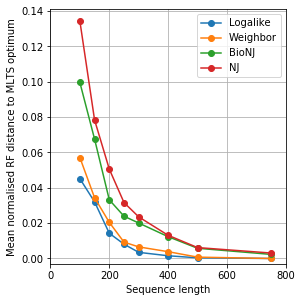

In [34]:
mnrf.plot(marker='o', figsize=figsize)
plt.grid()
plt.ylabel('Mean normalised RF distance to MLTS optimum')
plt.xlabel('Sequence length')
plt.ylim(-0.003)
plt.xlim(0, 800)
plt.tight_layout()
plt.savefig('article/sequence-length-rf-to-optimum-article.eps')
plt.show()


# Mean topological accuracy

Higher values are better.

In [35]:
topological_accuracy_report(df, gbcol)

,Logalike,Weighbor,BioNJ,NJ
sequence_length,,,,
100,0.177083,0.187500,0.031250,0.031250
150,0.427083,0.437500,0.177083,0.197917
200,0.645833,0.604167,0.406250,0.312500
250,0.802083,0.781250,0.552083,0.458333
300,0.875000,0.822917,0.614583,0.593750
400,0.927083,0.875000,0.729167,0.760417
500,0.989583,0.968750,0.864583,0.864583
750,0.989583,0.989583,0.937500,0.916667


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


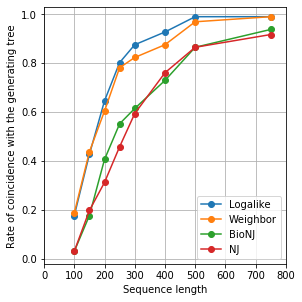

In [36]:
tar = topological_accuracy_report(df, gbcol)

tar.plot(marker='o', figsize=figsize)
plt.ylabel('Rate of coincidence with the generating tree')
plt.xlabel('Sequence length')

plt.ylim(-0.02, 1.03)
plt.xlim(0, 800)

plt.grid()
plt.tight_layout()
plt.savefig('article/sequence-length-experiment-topo-coincidence-article.eps')
plt.show()

# Number of rounds done

In [40]:
df['rounds_done'] = df.logalike_meta.apply(lambda d: d['rounds_done'])

In [43]:
df.rounds_done.mode()

0    1410
1    1598
2    2153
dtype: int64

In [44]:
sorted(df.rounds_done)

[791,
 793,
 837,
 847,
 938,
 961,
 972,
 987,
 987,
 987,
 988,
 1005,
 1015,
 1016,
 1021,
 1022,
 1054,
 1061,
 1075,
 1089,
 1103,
 1111,
 1121,
 1122,
 1123,
 1128,
 1129,
 1133,
 1136,
 1137,
 1142,
 1147,
 1150,
 1154,
 1160,
 1167,
 1175,
 1179,
 1183,
 1185,
 1190,
 1190,
 1193,
 1194,
 1200,
 1204,
 1210,
 1213,
 1230,
 1247,
 1254,
 1261,
 1262,
 1264,
 1266,
 1269,
 1275,
 1275,
 1276,
 1282,
 1297,
 1301,
 1302,
 1308,
 1309,
 1312,
 1314,
 1320,
 1324,
 1325,
 1328,
 1329,
 1337,
 1338,
 1344,
 1348,
 1354,
 1358,
 1369,
 1373,
 1373,
 1374,
 1376,
 1376,
 1381,
 1395,
 1397,
 1402,
 1402,
 1406,
 1407,
 1409,
 1409,
 1410,
 1410,
 1410,
 1410,
 1412,
 1414,
 1415,
 1415,
 1416,
 1416,
 1418,
 1422,
 1423,
 1423,
 1423,
 1427,
 1427,
 1429,
 1431,
 1432,
 1435,
 1435,
 1437,
 1439,
 1439,
 1442,
 1442,
 1452,
 1453,
 1458,
 1459,
 1460,
 1464,
 1467,
 1470,
 1474,
 1475,
 1479,
 1480,
 1484,
 1485,
 1488,
 1489,
 1492,
 1493,
 1493,
 1493,
 1496,
 1500,
 1500,
 1503,
 15

# Some failures with sequence length 50

There are 6 cases where the method has failed to converge - these are all for sequence length 50.  For 4 of these, the method errored.  This can just be attributed to a high amount of sample noise.  We'll simply ignore this case for the moment, and begin at sequence length 100, instead.

In [22]:
df.loc[~df.logalike_meta.apply(lambda d: d['converged'])]

,tree_seed,num_leaves,min_length,max_length,sequence_length,sequence_seed,dimension,rho,logalike_hyperparams,mds_hyperparams,...,bionj_rf-to-optimum,nj_duration,nj_meta,nj_tree,nj_ll,nj_rf-to-generating,nj_optimum-ll,nj_rf-to-optimum,generating_tree_ll,rounds_done
243,2,30,0.05,0.2,50,3,30,0.5,"{'lr': 0.1, 'max_step_size': 0.05, 'stopping_d...",{},...,8,0.011681,None,"[&U] ((T0025:0.036343387327228374,(T0028:0.246...",-1102.657,10,-1100.911,8,-1106.217,100000
351,3,30,0.05,0.2,50,3,30,0.5,"{'lr': 0.1, 'max_step_size': 0.05, 'stopping_d...",{},...,20,0.011444,None,"[&U] ((T0015:0.08817828721569042,T0010:0.17221...",-1222.817,24,-1199.888,22,-1200.167,23800
468,4,30,0.05,0.2,50,4,30,0.5,"{'lr': 0.1, 'max_step_size': 0.05, 'stopping_d...",{},...,12,0.011273,None,"[&U] (T0024:0.07771857530539814,(T0014:0.05039...",-1264.419,14,-1246.015,22,-1247.593,91808
558,5,30,0.05,0.2,50,2,30,0.5,"{'lr': 0.1, 'max_step_size': 0.05, 'stopping_d...",{},...,20,0.011206,None,"[&U] (T0019:0.04526412707784853,((T0006:0.0940...",-1161.700,10,-1149.376,12,-1149.388,27174
567,5,30,0.05,0.2,50,3,30,0.5,"{'lr': 0.1, 'max_step_size': 0.05, 'stopping_d...",{},...,20,0.011082,None,"[&U] ((T0019:0.0659551122738854,(((T0016:0.214...",-1257.902,22,-1209.018,26,-1212.787,100000
783,7,30,0.05,0.2,50,3,30,0.5,"{'lr': 0.1, 'max_step_size': 0.05, 'stopping_d...",{},...,10,0.011471,None,"[&U] (T0003:0.04936995409578503,(((T0023:0.164...",-1227.167,8,-1224.537,10,-1224.719,17785


In [24]:
df.loc[df.logalike_meta.apply(lambda d: d['failed'])]

,tree_seed,num_leaves,min_length,max_length,sequence_length,sequence_seed,dimension,rho,logalike_hyperparams,mds_hyperparams,...,bionj_rf-to-optimum,nj_duration,nj_meta,nj_tree,nj_ll,nj_rf-to-generating,nj_optimum-ll,nj_rf-to-optimum,generating_tree_ll,rounds_done
351,3,30,0.05,0.2,50,3,30,0.5,"{'lr': 0.1, 'max_step_size': 0.05, 'stopping_d...",{},...,20,0.011444,None,"[&U] ((T0015:0.08817828721569042,T0010:0.17221...",-1222.817,24,-1199.888,22,-1200.167,23800
468,4,30,0.05,0.2,50,4,30,0.5,"{'lr': 0.1, 'max_step_size': 0.05, 'stopping_d...",{},...,12,0.011273,None,"[&U] (T0024:0.07771857530539814,(T0014:0.05039...",-1264.419,14,-1246.015,22,-1247.593,91808
558,5,30,0.05,0.2,50,2,30,0.5,"{'lr': 0.1, 'max_step_size': 0.05, 'stopping_d...",{},...,20,0.011206,None,"[&U] (T0019:0.04526412707784853,((T0006:0.0940...",-1161.700,10,-1149.376,12,-1149.388,27174
783,7,30,0.05,0.2,50,3,30,0.5,"{'lr': 0.1, 'max_step_size': 0.05, 'stopping_d...",{},...,10,0.011471,None,"[&U] (T0003:0.04936995409578503,(((T0023:0.164...",-1227.167,8,-1224.537,10,-1224.719,17785
